# 2.6.1 特征空间可视化

## 2.6.1.1 特征可视化

读取图像，显示样本标记的标签：

In [1]:
from skimage.io import imread, imsave
img = imread('Hyperspectral_Project/dc.tif')
img.shape

(191, 1280, 307)

In [2]:
import numpy as np
from skimage.exposure import rescale_intensity

#选取第60、27和17波段，组合成RGB图像
img_RGB = np.dstack([img[59, :, :], img[26, :, :], img[16, :, :]])

#对图像进行对比度拉伸，放缩到0-255的数值范围
p_10, p_90 = np.percentile(img_RGB, (10, 90))

img_rescale = rescale_intensity(img_RGB,
                                in_range=(p_10, p_90),
                                out_range=(0, 255))

img_rescale = img_rescale.astype('uint8')
imsave('hyperspectral_img_RGB.png', img_rescale)

In [3]:
from skimage.io import imread, imsave
img = imread('Hyperspectral_Project/dc.tif')

import numpy as np
from skimage.exposure import rescale_intensity
#选取第60、27和17波段，组合成RGB图像
img_RGB = np.dstack([img[59, :, :], img[26, :, :], img[16, :, :]])
#对图像进行对比度拉伸，放缩到0-255的数值范围
p_10, p_90 = np.percentile(img_RGB, (10, 90))
img_rescale = rescale_intensity(img_RGB,
                                in_range=(p_10, p_90),
                                out_range=(0, 255))
img_rescale = img_rescale.astype('uint8')

In [4]:
def get_label(file_path):
    with open(file_path, 'r') as label_file:
        label_data = label_file.readlines()[13:]
    label_list = []
    region_list = []
    for i in range(len(label_data) // 3):
        #解析文件，获得标注区域的标签、左上角像素坐标和右下角像素坐标
        label = label_data[i * 3].split('\t')[4]
        r_1, c_1 = label_data[i * 3 + 1][:-1].split('\t')[1:]
        r_2, c_2 = label_data[i * 3 + 2][:-1].split('\t')[1:]
        label_list.append(int(label) - 1)
        region_list.append((int(r_1) - 1, int(c_1) - 1, int(r_2), int(c_2)))
    return label_list, region_list

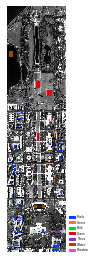

In [5]:
from skimage import color
from skimage.io import imshow
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patches
gray_img = color.rgb2gray(img_rescale)
gray_img = gray_img.reshape(img.shape[1], img.shape[2], 1)
gray_img = gray_img.repeat(3, axis=2)
file_path = 'Hyperspectral_Project/dctest.project'
label_list, region_list = get_label(file_path)
colors = sns.color_palette('bright')
for label, region in zip(label_list, region_list):
    gray_img[region[0]:region[2], region[1]:region[3]] = colors[label]
imshow(gray_img)
labels = ['Roofs', 'Street', 'Path', 'Grass', 'Trees', 'Water', 'Shadow']
legend_patches = []
for i in range(len(labels)):
    legend_patches.append(patches.Patch(color=colors[i], label=labels[i]))
plt.legend(handles=legend_patches,
           loc='lower left',
           fontsize=3,
           frameon=False,
           bbox_to_anchor=(1, -0.01))
plt.axis('off')
plt.savefig('hyperspectral_img_label.pdf', bbox_inches='tight', dpi=600)

In [6]:
import requests
from bs4 import BeautifulSoup
import numpy as np
html_url = 'https://www.lars.purdue.edu/home/image_data/hydice_dc_wavelengths.html'
res = requests.get(html_url)
soup = BeautifulSoup(res.text, 'html.parser')
wavelength_list = []
for item in soup.find_all('br'):
    band_str = item.next_sibling.split()
    if band_str[-1] != 'x':
        wavelength_list.append(float(band_str[-2]))
wavelength_table = np.array(wavelength_list)


显示光谱曲线：

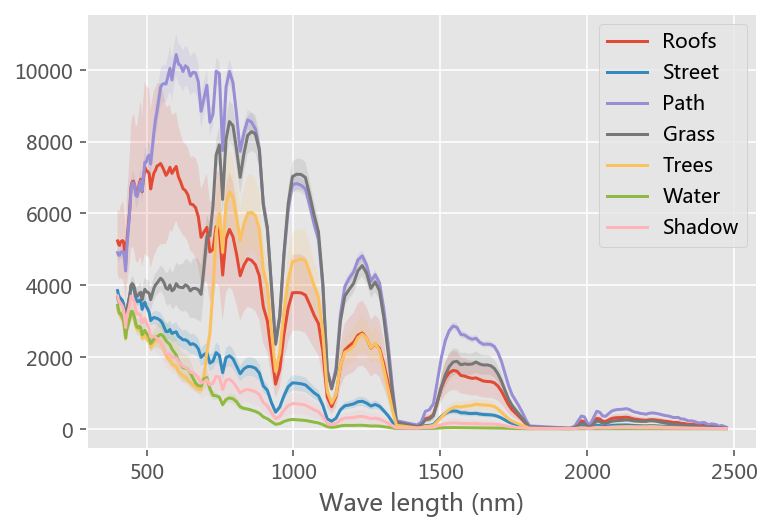

In [88]:
y_label  = np.array(label_list)
y_region = np.array(region_list)

pixel_mean_value_list = []
pixel_std_value_list = []
label_index_list = []

X_list = []

for item in set(label_list):
    same_label_region = y_region[y_label==item]
    region_img_list = []
    for region in same_label_region:
        region_img = img[:,region[0]:region[2],region[1]:region[3]]
        region_img = region_img.transpose((1,2,0)).reshape(-1,img.shape[0])
        region_img_list.append(region_img)
        
    pixel_mean_value = np.concatenate(region_img_list,axis=0).mean(axis=0)
    pixel_mean_value_list.append(pixel_mean_value)
    
    pixel_std_value = np.concatenate(region_img_list,axis=0).std(axis=0)
    pixel_std_value_list.append(pixel_std_value)
    
    label_index_list.append(item)
    
    X_list.append(np.concatenate(region_img_list,axis=0))

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.style.use('ggplot')

#正常显示中文标签
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
#正常显示负号
plt.rcParams['axes.unicode_minus'] = False

for l, p_mean, p_std in zip(label_index_list, pixel_mean_value_list,pixel_std_value_list):
    plt.plot(wavelength_table, p_mean, label=labels[l])
    plt.fill_between(
    wavelength_table,
    p_mean + p_std,
    p_mean - p_std,
    alpha=0.15,)
plt.legend()
plt.xlabel('Wave length (nm)')
plt.savefig('class_mean_spectral_curve_fill.pdf', bbox_inches='tight')

特征组合显示：

In [12]:
from skimage.io import imread

def load_hyperspectral_data(img_file_path,label_file_path):
    img = imread(img_file_path)
    label_list, region_list = get_label(label_file_path)
    
    y_regions  = np.array(label_list)
    X_regions = np.array(region_list)
    X_list = []
    y_list = []
    pixel_position_list = []
    
    for region_i, label_i in zip(region_list,label_list):
        
        for row in range(region_i[0],region_i[2]):
            for column in range(region_i[1],region_i[3]):
                X_list.append(img[:,row,column].reshape((img.shape[0],)))
                y_list.append(label_i)
                pixel_position_list.append([row,column])

    X = np.array(X_list)
    y = np.array(y_list)
    pixel_position = np.array(pixel_position_list)
    return X,y,pixel_position
    

In [13]:
img_file_path = 'Hyperspectral_Project/dc.tif'
label_file_path = 'Hyperspectral_Project/dctest.project'
X,y,pixel_position = load_hyperspectral_data(img_file_path,label_file_path)

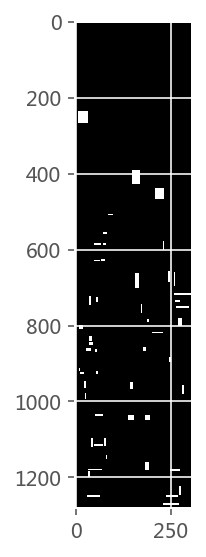

In [45]:
#测试像素位置是否正确
img_and_label_test = np.zeros((1280, 307),dtype = np.uint8)
for p_i in pixel_position:
    img_and_label_test[p_i[0],p_i[1]] = 255 
imshow(img_and_label_test)

In [48]:
B = X[:,6:14].mean(axis = 1)
G = X[:,24:37].mean(axis = 1)
R = X[:,45:61].mean(axis = 1)
NIR = X[:,61:82].mean(axis = 1)
MIR = X[:,82:].mean(axis = 1)


In [49]:
NDVI = (NIR-R)/(NIR+R)
MNDWI= (G-MIR)/(G+MIR)
NDBI = (MIR-NIR)/(MIR+NIR)


In [75]:
input_x = np.concatenate(
    [NDVI.reshape((-1, 1)),
     MNDWI.reshape((-1, 1)),
     NDBI.reshape((-1, 1))],
    axis=1)
input_y = [labels[item] for item in y]

In [76]:
input_x.shape

(8079, 3)

In [80]:
import pandas as pd
import seaborn as sns
input_pd = pd.DataFrame(input_x,columns=['NDVI','MNDWI','NDBI'])
input_pd['Categories']= input_y

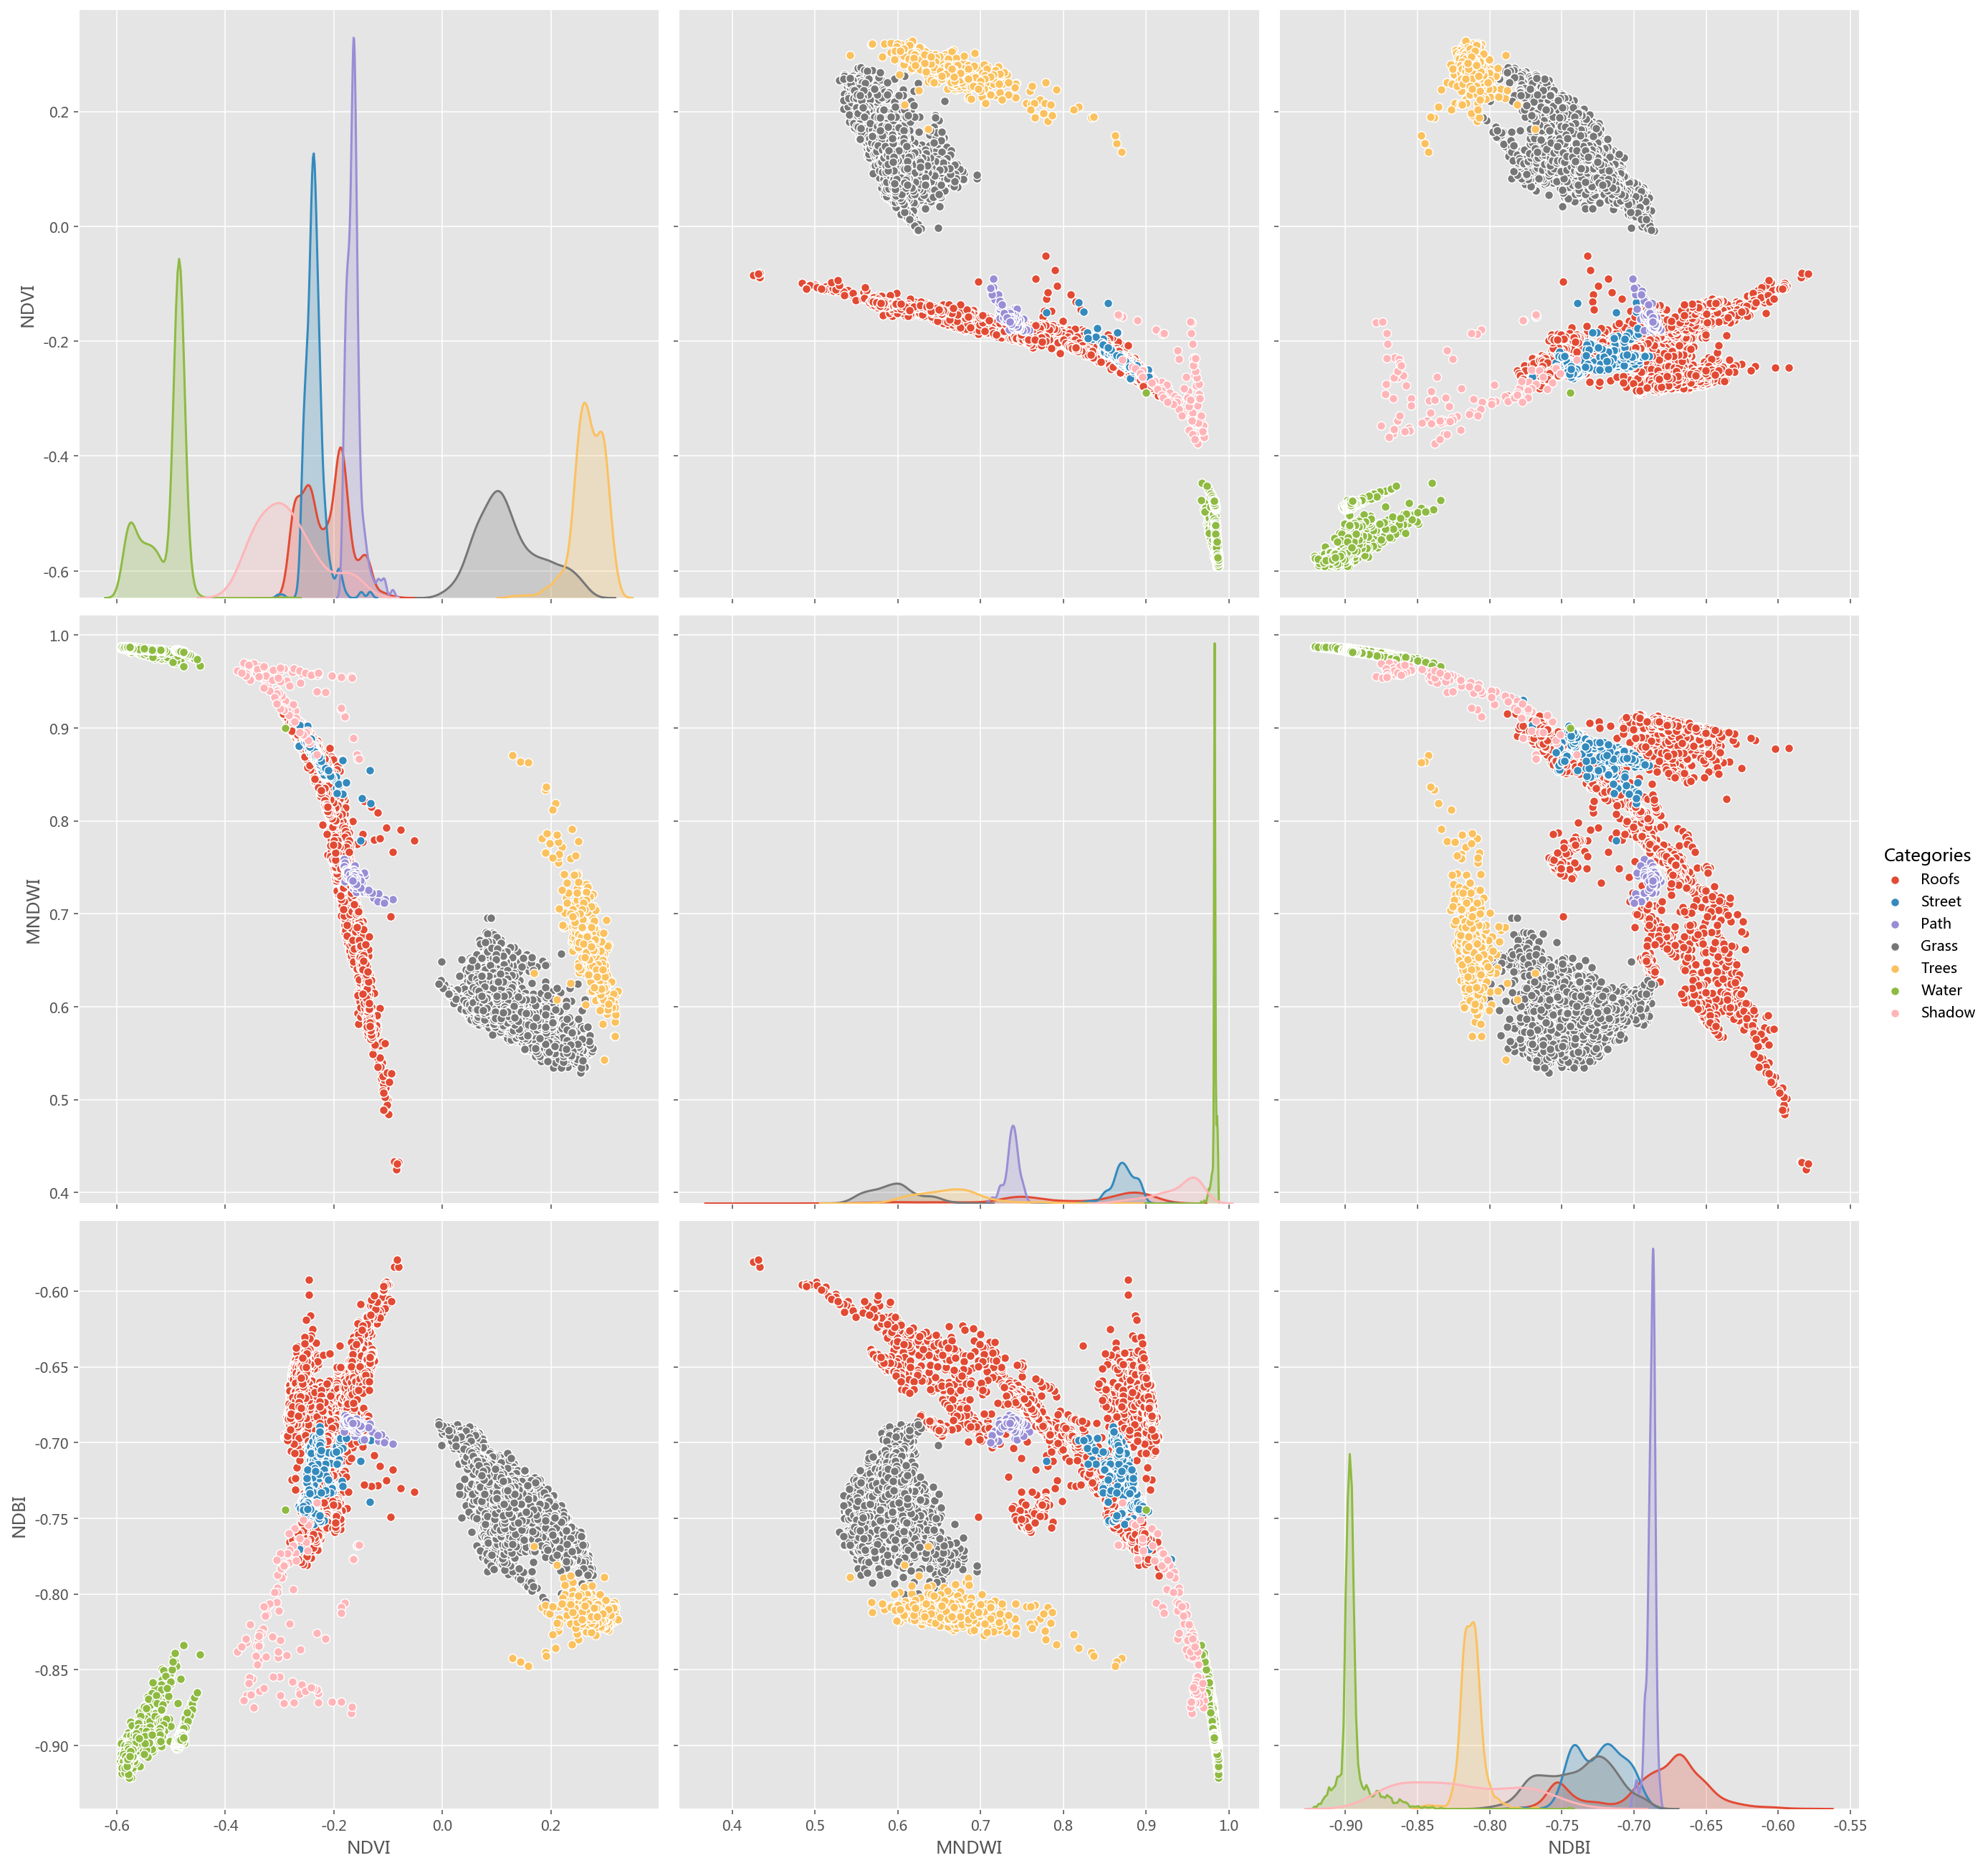

In [190]:
sns.pairplot(input_pd, hue='Categories', height=6,
             #plot_kws=dict(s=10),
             #diag_kws=dict(shade=True),
            )
plt.savefig('pairplot_spectral_index_small.pdf', bbox_inches='tight')

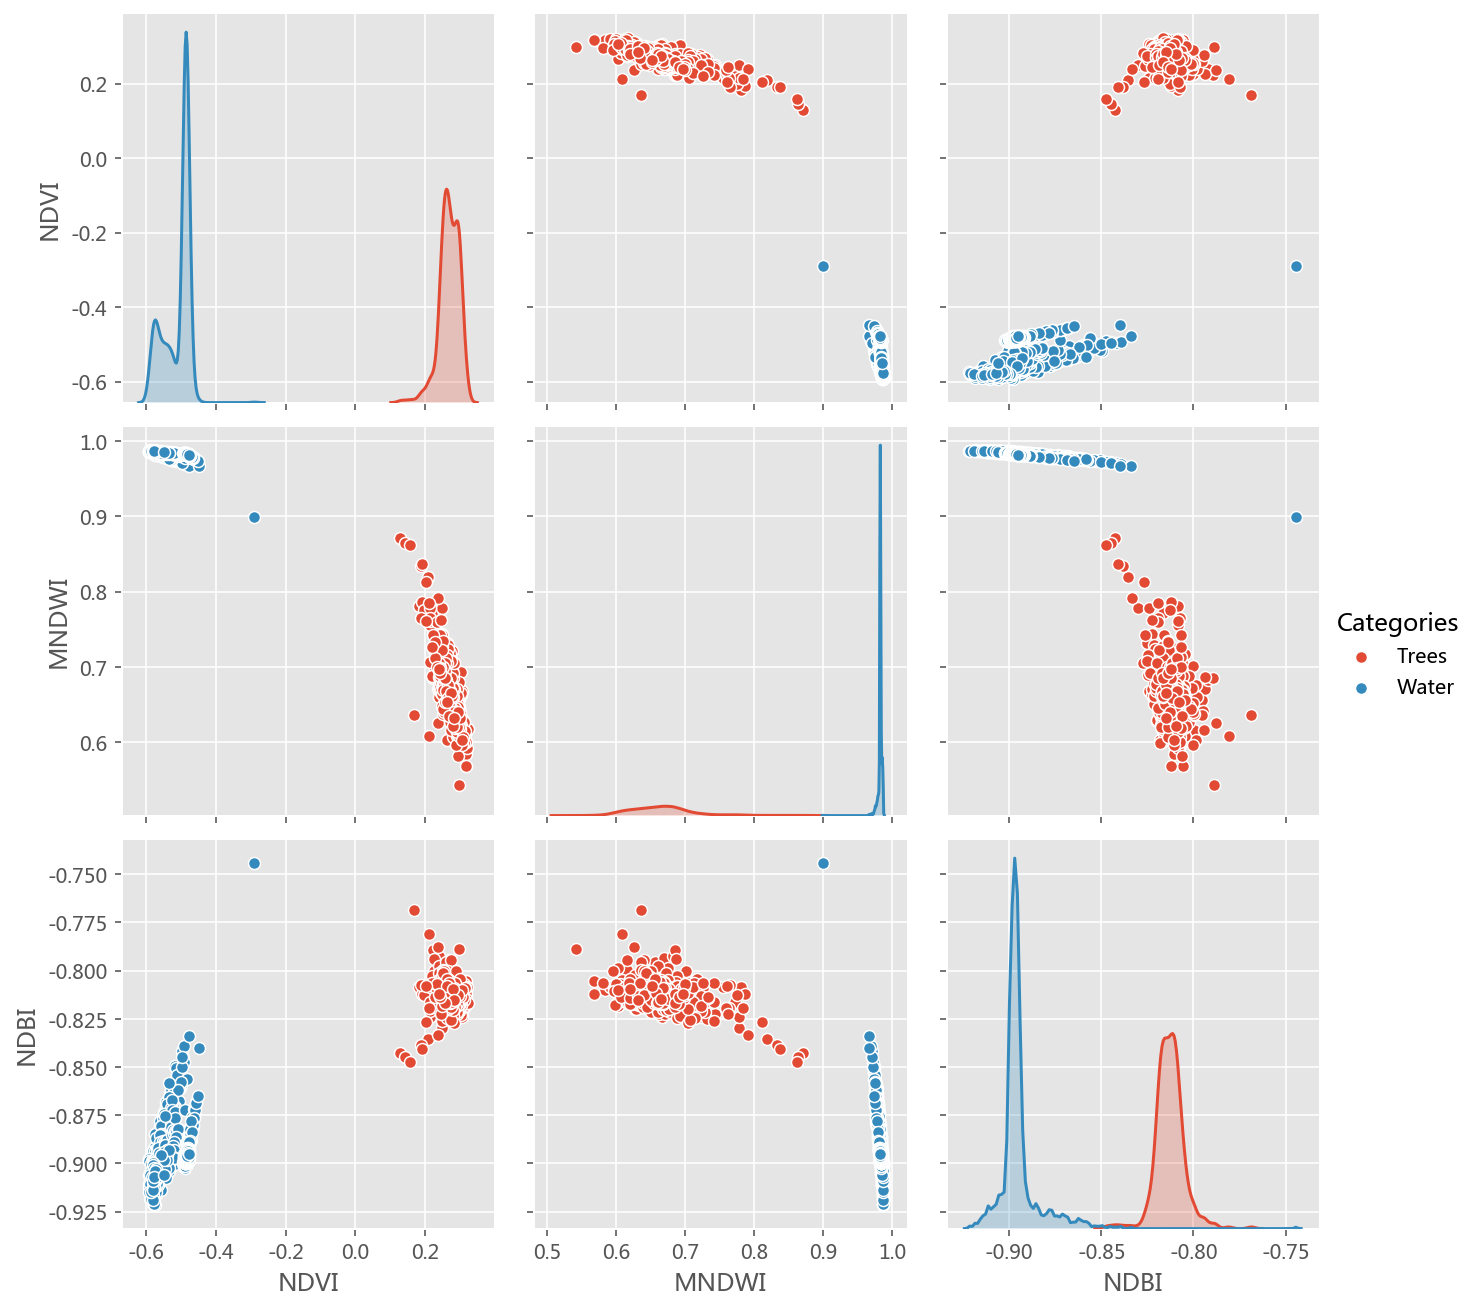

In [105]:
sns.pairplot(input_pd[(input_pd['Categories']=='Trees') | (input_pd['Categories']=='Water')], 
             hue='Categories', height=3,
             #plot_kws=dict(s=10),
             #diag_kws=dict(shade=True),
            )
plt.savefig('pairplot_spectral_index_Trees_Water.pdf', bbox_inches='tight')

['Roofs', 'Street', 'Path', 'Grass', 'Trees', 'Water', 'Shadow']

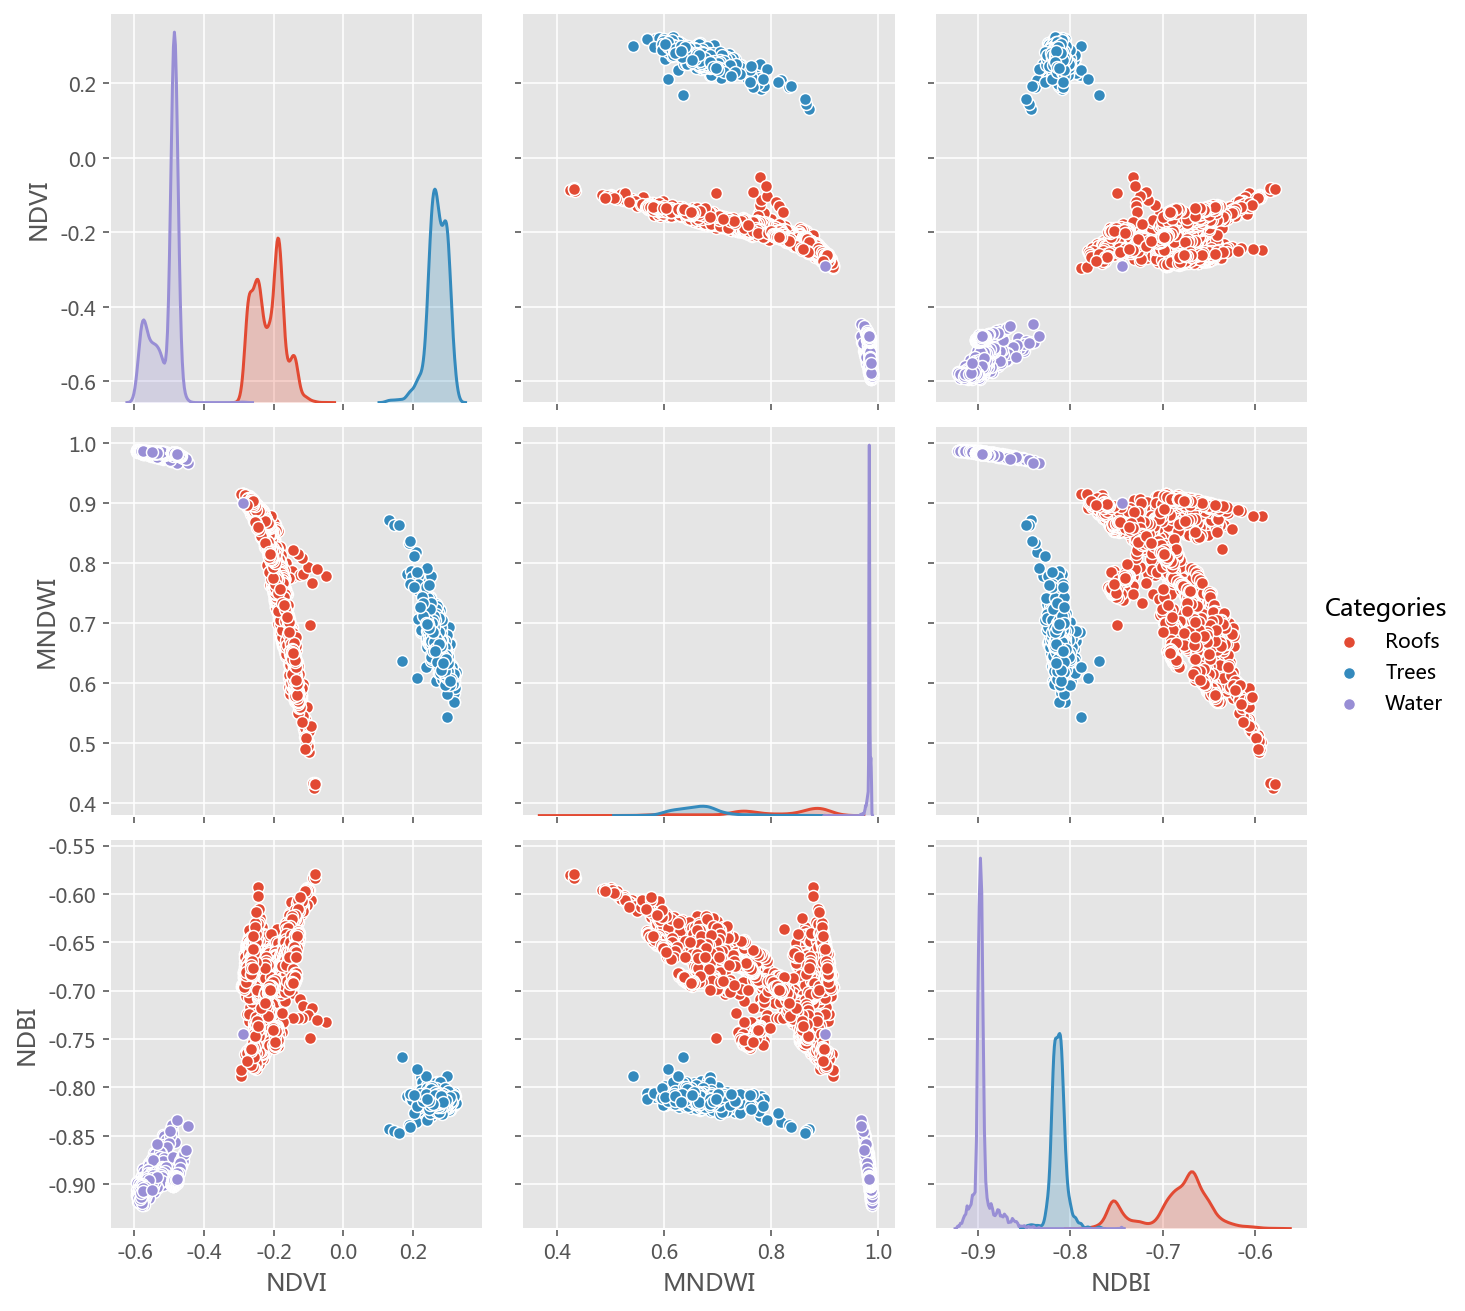

In [107]:
sns.pairplot(input_pd[(input_pd['Categories']=='Trees') 
                      | (input_pd['Categories']=='Water')
                      | (input_pd['Categories']=='Roofs')], 
             hue='Categories', height=3,
             #plot_kws=dict(s=10),
             #diag_kws=dict(shade=True),
            )
plt.savefig('pairplot_spectral_index_Trees_Water_Roofs.pdf', bbox_inches='tight')

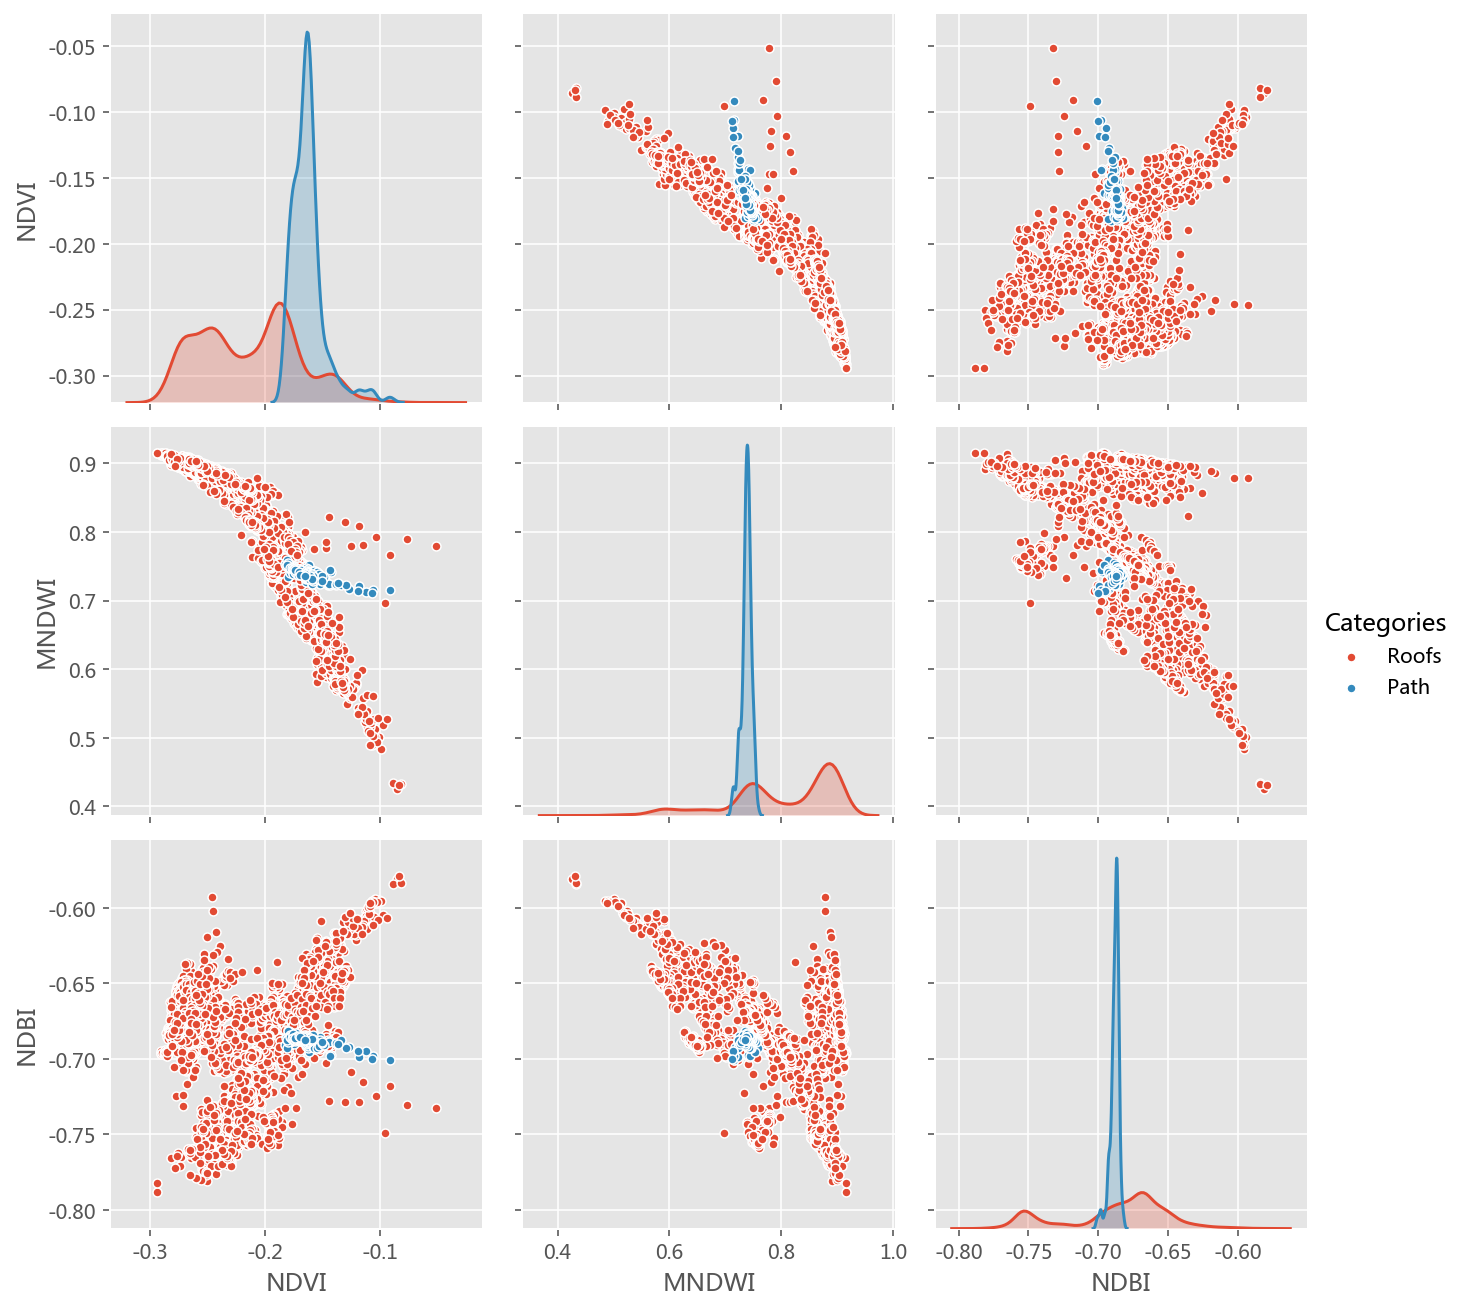

In [178]:
sns.pairplot(input_pd[(input_pd['Categories']=='Roofs') | (input_pd['Categories']=='Path')], 
             hue='Categories', height=3,
             plot_kws=dict(s=20),
            )
plt.savefig('pairplot_spectral_index_Roofs_Path.pdf', bbox_inches='tight')

labels = ['Roofs', 'Street', 'Path', 'Grass', 'Trees', 'Water', 'Shadow']

In [313]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=100, linewidth=1, edgecolors='k' ,facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [314]:
def select_categories_visulization(selected_categories):

    selected_data = input_pd[(input_pd['Categories'] == selected_categories[0]) |
                           (input_pd['Categories'] == selected_categories[1])]
    model = SVC(kernel='linear', C=1e10)



    features = selected_data.drop(['Categories','NDBI'],axis=1)
    target = selected_data['Categories']
    model.fit(features, target)

    sns.relplot(data=selected_data,
                x='NDVI',
                y='MNDWI',
                hue='Categories',)
    plot_svc_decision_function(model)

In [307]:
def select_nonlinear_svm_categories_visulization(selected_categories):

    selected_data = input_pd[(input_pd['Categories'] == selected_categories[0]) |
                           (input_pd['Categories'] == selected_categories[1])]
    model = SVC(gamma='auto',C=10000)



    features = selected_data.drop(['Categories','NDVI'],axis=1)
    target = selected_data['Categories']
    model.fit(features, target)

    sns.relplot(data=selected_data,
                y='NDBI',
                x='MNDWI',
                hue='Categories',s=20)
    #plt.xlim(0.65,0.80)
    #plt.ylim(-0.74,-0.66)  
    #ax = plt.gca()
    #ax.set_aspect(1.5) 
    plot_nonlinear_svc_decision_function(model)

## 2.6.1.2 线性可分数据

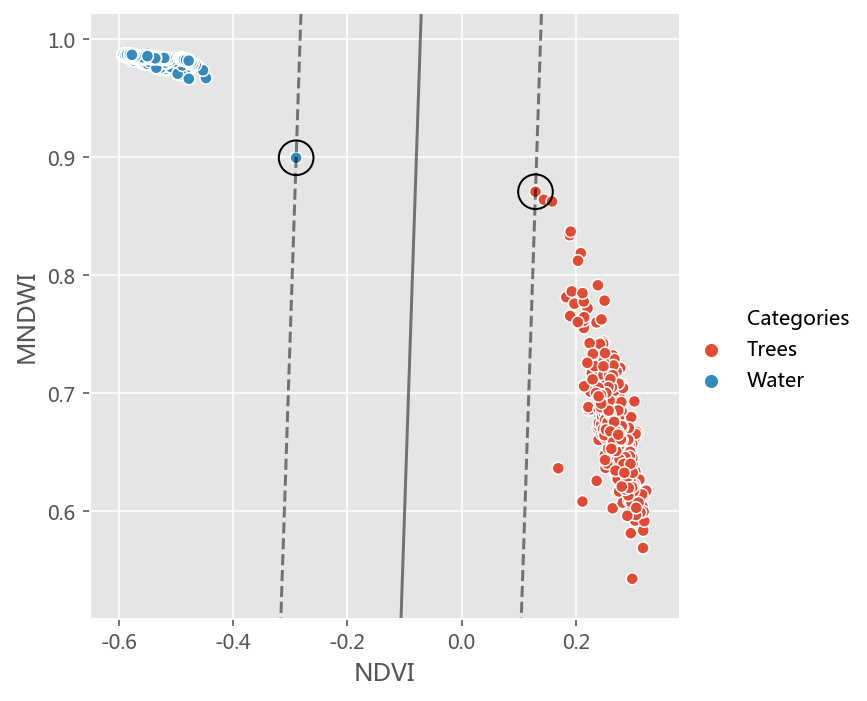

In [234]:
selected_categories = ['Trees', 'Water']
select_categories_visulization(selected_categories)
plt.savefig(
    f'linear_SVM_{selected_categories[0]}_{selected_categories[1]}.pdf',
    bbox_inches='tight')

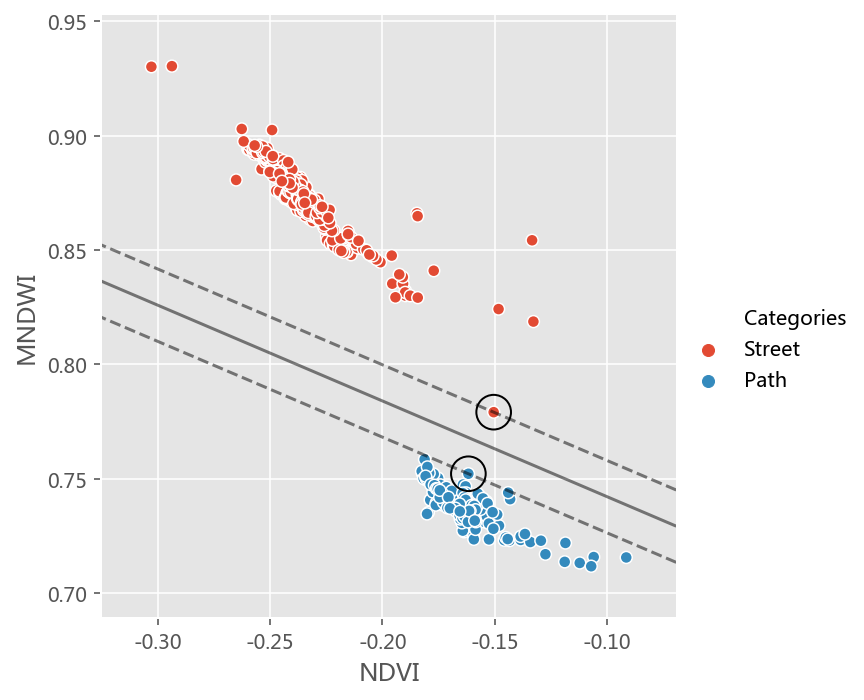

In [215]:
selected_categories = ['Street', 'Path']
select_categories_visulization(selected_categories)
plt.savefig(
    f'linear_SVM_{selected_categories[0]}_{selected_categories[1]}.pdf',
    bbox_inches='tight')

In [221]:
input_pd['Categories'].str.contains

<bound method StringMethods.contains of <pandas.core.strings.StringMethods object at 0x7fc7dcb0eed0>>

In [231]:
def select_multiple_categories_visulization(selected_categories):

    selected_data_index = input_pd['Categories'].str.contains('|'.join(selected_categories),
                                          regex=True)
    selected_data = input_pd[selected_data_index]
    
    model = SVC(kernel='linear', C=1e10)

    features = selected_data.drop(['Categories', 'NDBI'], axis=1)
    target = selected_data['Categories']
    model.fit(features, target)

    sns.relplot(
        data=selected_data,
        x='NDVI',
        y='MNDWI',
        hue='Categories',
    )
    plot_svc_decision_function(model)

In [ ]:
def plot_nonlinear_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   #alpha=0.5,
                   s=60, 
                   linewidth=1, 
                   edgecolors='k' ,
                   #zorder = -1,
                   facecolors='none');
    ax.set_xlim(xlim)

In [331]:
selected_categories = ['Roofs', 'Path']
selected_data_index = input_pd['Categories'].str.contains('|'.join(selected_categories),
                                          regex=True)
selected_data = input_pd[selected_data_index]
    
X = selected_data.drop(['Categories', 'NDBI'], axis=1)
y = selected_data['Categories']

In [565]:
input_pd.head()

NDVI     MNDWI      NDBI Categories
0 -0.217501  0.846118 -0.696678      Roofs
1 -0.265833  0.892869 -0.675075      Roofs
2 -0.269815  0.897565 -0.666396      Roofs
3 -0.273643  0.900506 -0.666377      Roofs
4 -0.278948  0.904283 -0.675293      Roofs

In [613]:

from matplotlib import cm


cmap = sns.diverging_palette(200,20,sep=20,as_cmap=True)

def plot_mlp_decision_function(model, ax=None):
    """Plot the decision function"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    x = np.linspace(xlim[0], xlim[1], 200)
    y = np.linspace(ylim[0], ylim[1], 200)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    
    if hasattr(model, "decision_function"):
        Z = model.decision_function(xy)
    else:
        Z = model.predict_proba(xy)[:, 1]

    Z = Z.reshape(X.shape)
    
    norm = cm.colors.Normalize(vmax=1, vmin=0)


    levels = np.arange(0,1.01,0.1)

    cset1 = ax.contourf(X, Y, Z, levels, 
                        norm=norm,
                        alpha=.9,
                        zorder = -2,
                        cmap=cm.get_cmap(cmap, len(levels) - 1))  
    
    cset2 = ax.contour(X, Y, Z, cset1.levels,linewidths=0.5,
                       alpha=.5,
                       colors='k',
                      zorder = -1)
    
    for c in cset2.collections:
        c.set_linestyle('--')
    
    cset3 = ax.contour(X, Y, Z, (0.5,), colors='k', alpha=.8,linewidths=1.5,zorder = -1)
    plt.colorbar(cset1,
                 orientation='horizontal',
                 fraction=0.05, 
                 ax=ax)

    ax.set_xlim(xlim)

## 2.6.1.3 非线性可分数据

In [563]:
from sklearn.neural_network import MLPClassifier

def select_mlp_categories_visulization(selected_categories):

    selected_data = input_pd[(input_pd['Categories'] == selected_categories[0]) |
                           (input_pd['Categories'] == selected_categories[1])]
    
    model = MLPClassifier(hidden_layer_sizes=(200,200,200),
                          alpha=1e-6,
                          tol=1e-7,
                          max_iter=2000,
                          random_state=7,
                         )



    features = selected_data.drop(['Categories','NDVI'],axis=1)
    target = selected_data['Categories']
    model.fit(features, target)


    sns.relplot(data=selected_data,
                y='NDBI',
                x='MNDWI',
                hue='Categories',s=10)
    plt.xlim(0.65,0.80)
    plt.ylim(-0.74,-0.66)  
    ax = plt.gca()
    ax.set_aspect(1.5) 
    
    plt.grid(b=False)
    
    plot_mlp_decision_function(model)
    

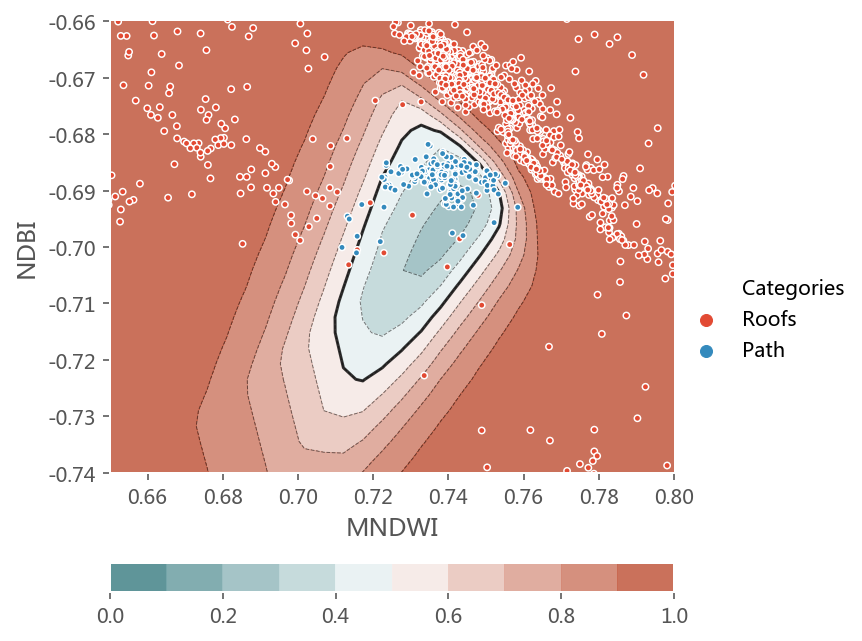

In [554]:
selected_categories = ['Roofs', 'Path']
select_mlp_categories_visulization(selected_categories)

plt.savefig(
    f'mlp_{selected_categories[0]}_{selected_categories[1]}.pdf',
    bbox_inches='tight')

In [ ]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    

    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, 
                           #clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

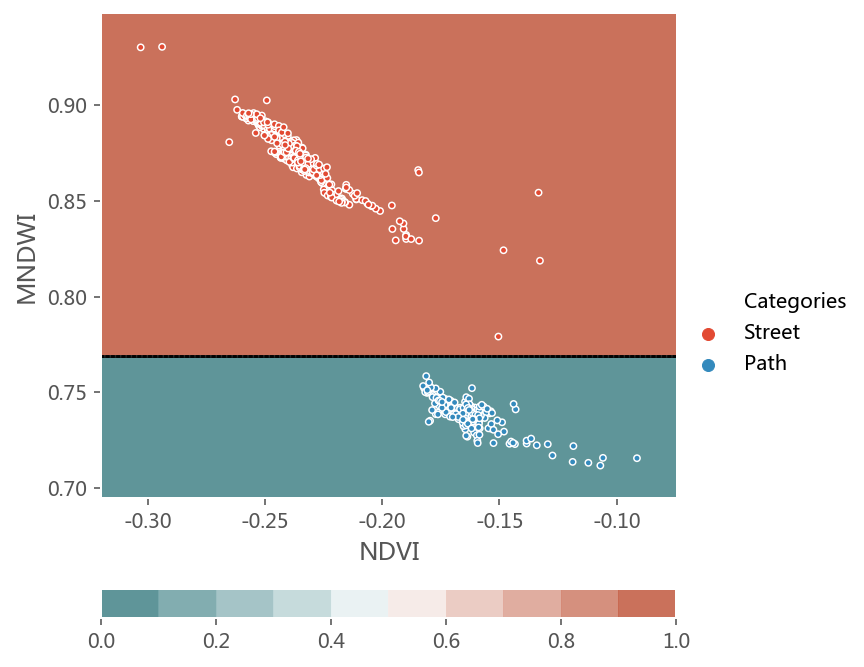

In [616]:
selected_categories = ['Street', 'Path']

from sklearn.tree import DecisionTreeClassifier



selected_data = input_pd[(input_pd['Categories'] == selected_categories[0]) |
                       (input_pd['Categories'] == selected_categories[1])]

model = DecisionTreeClassifier()



features = selected_data.drop(['Categories','NDBI'],axis=1)
target = selected_data['Categories']
model.fit(features, target)


sns.relplot(data=selected_data,
            x='NDVI',
            y='MNDWI',
            hue='Categories',s=10)

plt.grid(b=False)

plot_mlp_decision_function(model)

plt.savefig(
    f'DecisionTree_{selected_categories[0]}_{selected_categories[1]}.pdf',
    bbox_inches='tight')

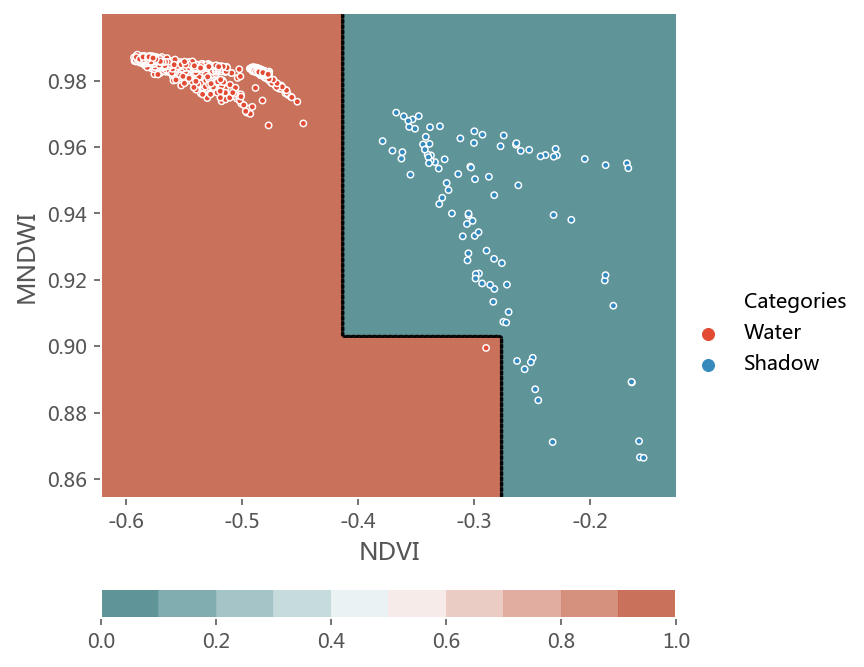

In [615]:
selected_categories = ['Shadow','Water']

from sklearn.tree import DecisionTreeClassifier



selected_data = input_pd[(input_pd['Categories'] == selected_categories[0]) |
                       (input_pd['Categories'] == selected_categories[1])]

model = DecisionTreeClassifier()



features = selected_data.drop(['Categories','NDBI'],axis=1)
target = selected_data['Categories']
model.fit(features, target)


sns.relplot(data=selected_data,
            x='NDVI',
            y='MNDWI',
            hue='Categories',s=10)

plt.grid(b=False)

plot_mlp_decision_function(model)

plt.savefig(
    f'DecisionTree_{selected_categories[0]}_{selected_categories[1]}.pdf',
    bbox_inches='tight')

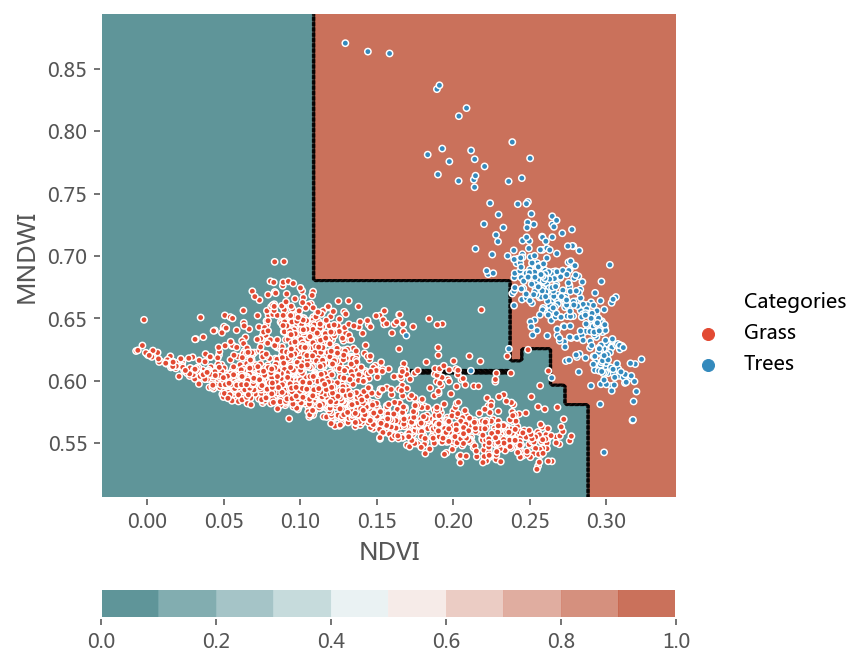

In [614]:
from sklearn.neural_network import MLPClassifier

selected_categories = ['Grass','Trees']


selected_data = input_pd[(input_pd['Categories'] == selected_categories[0]) |
                       (input_pd['Categories'] == selected_categories[1])]

model = DecisionTreeClassifier()



features = selected_data.drop(['Categories','NDBI'],axis=1)
target = selected_data['Categories']
model.fit(features, target)


sns.relplot(data=selected_data,
            x='NDVI',
            y='MNDWI',
            hue='Categories',s=10)

plt.grid(b=False)

plot_mlp_decision_function(model)

plt.savefig(
    f'DecisionTree_{selected_categories[0]}_{selected_categories[1]}.pdf',
    bbox_inches='tight')

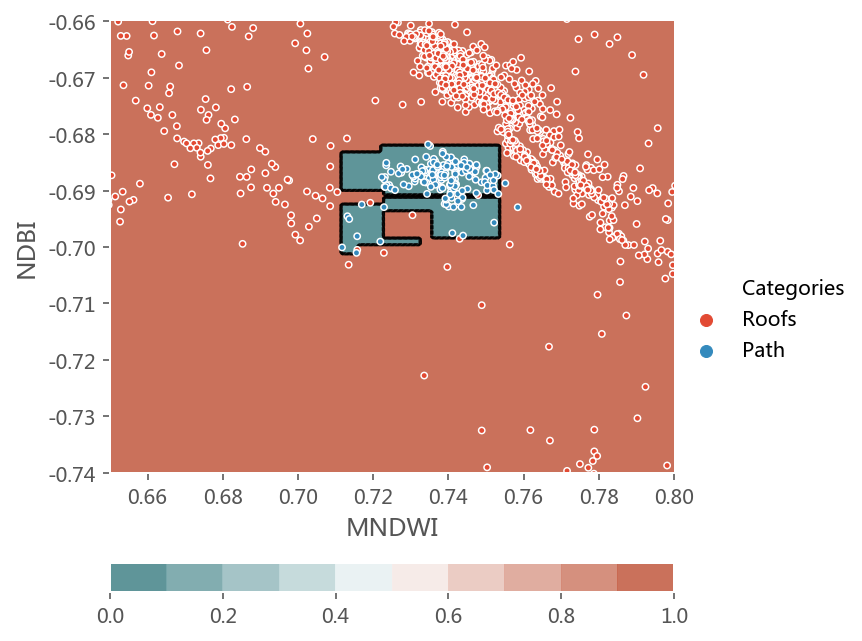

In [617]:
selected_categories = ['Roofs', 'Path']

selected_data = input_pd[(input_pd['Categories'] == selected_categories[0]) |
                       (input_pd['Categories'] == selected_categories[1])]
model = DecisionTreeClassifier()



features = selected_data.drop(['Categories','NDVI'],axis=1)
target = selected_data['Categories']
model.fit(features, target)


sns.relplot(data=selected_data,
            y='NDBI',
            x='MNDWI',
            hue='Categories',s=10)
plt.xlim(0.65,0.80)
plt.ylim(-0.74,-0.66)  
ax = plt.gca()
ax.set_aspect(1.5) 

plt.grid(b=False)

plot_mlp_decision_function(model)

plt.savefig(
    f'DecisionTree_{selected_categories[0]}_{selected_categories[1]}.pdf',
    bbox_inches='tight')

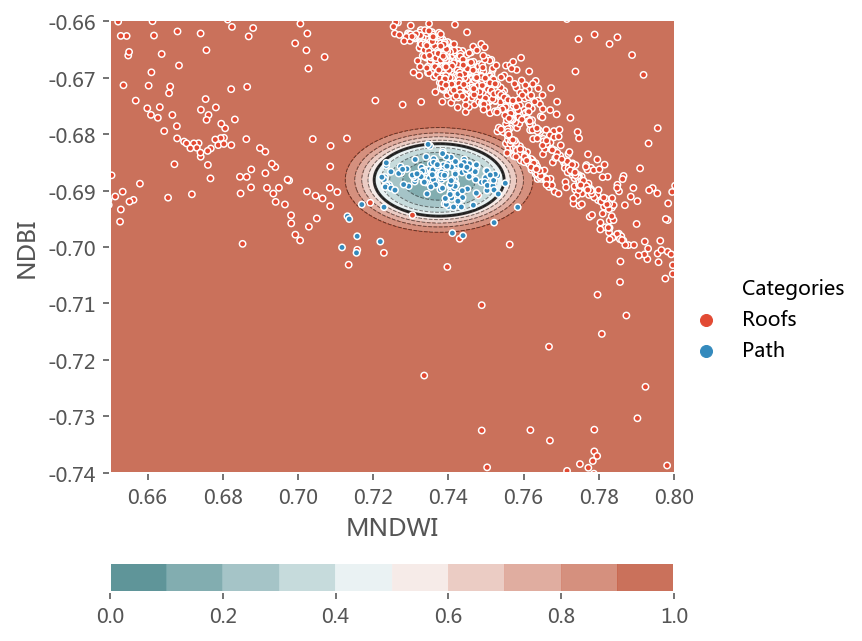

In [618]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

selected_categories = ['Roofs', 'Path']

selected_data = input_pd[(input_pd['Categories'] == selected_categories[0]) |
                       (input_pd['Categories'] == selected_categories[1])]
model = clf



features = selected_data.drop(['Categories','NDVI'],axis=1)
target = selected_data['Categories']
model.fit(features, target)


sns.relplot(data=selected_data,
            y='NDBI',
            x='MNDWI',
            hue='Categories',s=10)
plt.xlim(0.65,0.80)
plt.ylim(-0.74,-0.66)  
ax = plt.gca()
ax.set_aspect(1.5) 

plt.grid(b=False)

plot_mlp_decision_function(model)

plt.savefig(
    f'Gaussian_naive_bayes_{selected_categories[0]}_{selected_categories[1]}.pdf',
    bbox_inches='tight')

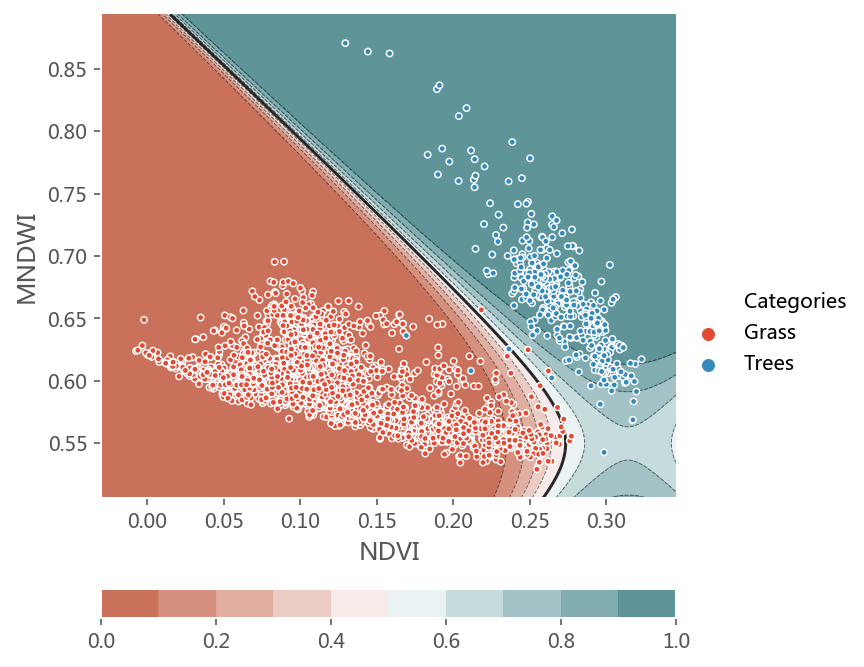

In [620]:
from sklearn.neural_network import MLPClassifier

selected_categories = ['Grass','Trees']
clf = GaussianNB()
cmap = sns.diverging_palette(20,200,sep=20,as_cmap=True)

selected_data = input_pd[(input_pd['Categories'] == selected_categories[0]) |
                       (input_pd['Categories'] == selected_categories[1])]

model = clf



features = selected_data.drop(['Categories','NDBI'],axis=1)
target = selected_data['Categories']
model.fit(features, target)


sns.relplot(data=selected_data,
            x='NDVI',
            y='MNDWI',
            hue='Categories',s=10)

plt.grid(b=False)

plot_mlp_decision_function(model)

plt.savefig(
    f'Gaussian_naive_bayes_{selected_categories[0]}_{selected_categories[1]}.pdf',
    bbox_inches='tight')

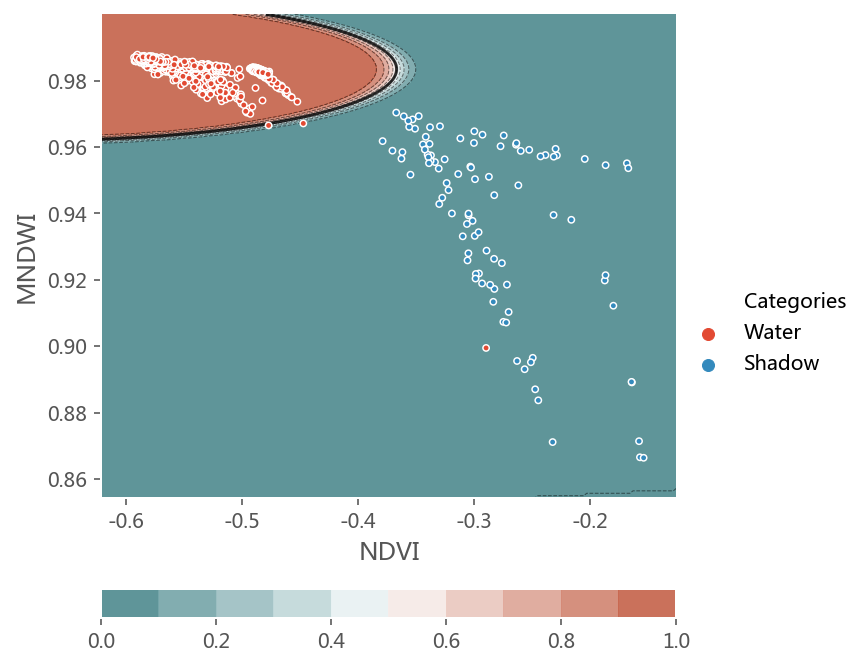

In [622]:
selected_categories = ['Shadow','Water']

cmap = sns.diverging_palette(200,20,sep=20,as_cmap=True)
clf = GaussianNB()

selected_data = input_pd[(input_pd['Categories'] == selected_categories[0]) |
                       (input_pd['Categories'] == selected_categories[1])]

model = clf



features = selected_data.drop(['Categories','NDBI'],axis=1)
target = selected_data['Categories']
model.fit(features, target)


sns.relplot(data=selected_data,
            x='NDVI',
            y='MNDWI',
            hue='Categories',s=10)

plt.grid(b=False)

plot_mlp_decision_function(model)

plt.savefig(
    f'Gaussian_naive_bayes_{selected_categories[0]}_{selected_categories[1]}.pdf',
    bbox_inches='tight')

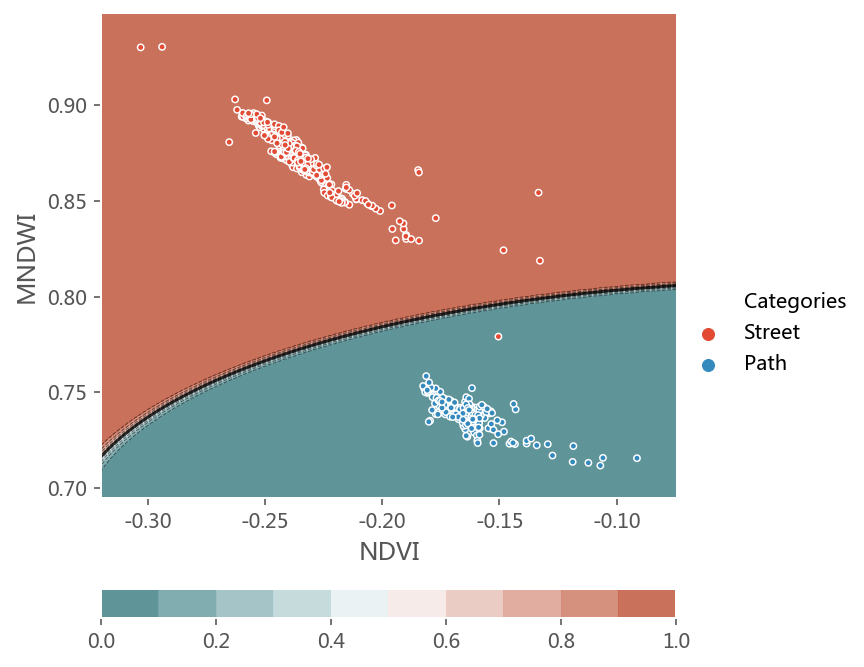

In [623]:
selected_categories = ['Street', 'Path']

from sklearn.tree import DecisionTreeClassifier


clf = GaussianNB()
selected_data = input_pd[(input_pd['Categories'] == selected_categories[0]) |
                       (input_pd['Categories'] == selected_categories[1])]

model = clf



features = selected_data.drop(['Categories','NDBI'],axis=1)
target = selected_data['Categories']
model.fit(features, target)


sns.relplot(data=selected_data,
            x='NDVI',
            y='MNDWI',
            hue='Categories',s=10)

plt.grid(b=False)

plot_mlp_decision_function(model)

plt.savefig(
    f'Gaussian_naive_bayes_{selected_categories[0]}_{selected_categories[1]}.pdf',
    bbox_inches='tight')

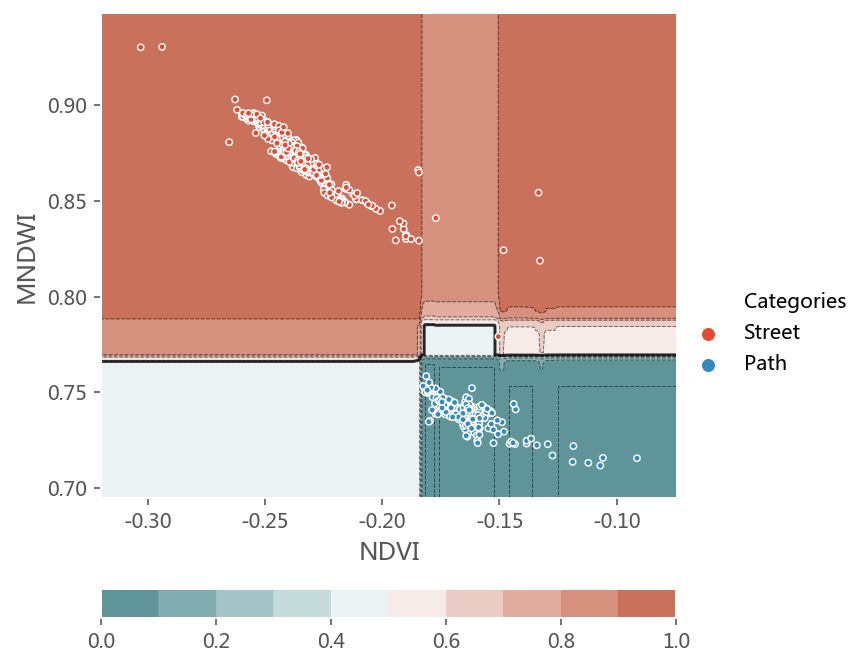

In [624]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=1000, random_state=0)

selected_categories = ['Street', 'Path']


selected_data = input_pd[(input_pd['Categories'] == selected_categories[0]) |
                       (input_pd['Categories'] == selected_categories[1])]




features = selected_data.drop(['Categories','NDBI'],axis=1)
target = selected_data['Categories']
model.fit(features, target)


sns.relplot(data=selected_data,
            x='NDVI',
            y='MNDWI',
            hue='Categories',s=10)

plt.grid(b=False)

plot_mlp_decision_function(model)

plt.savefig(
    f'RandomForest_{selected_categories[0]}_{selected_categories[1]}.pdf',
    bbox_inches='tight')

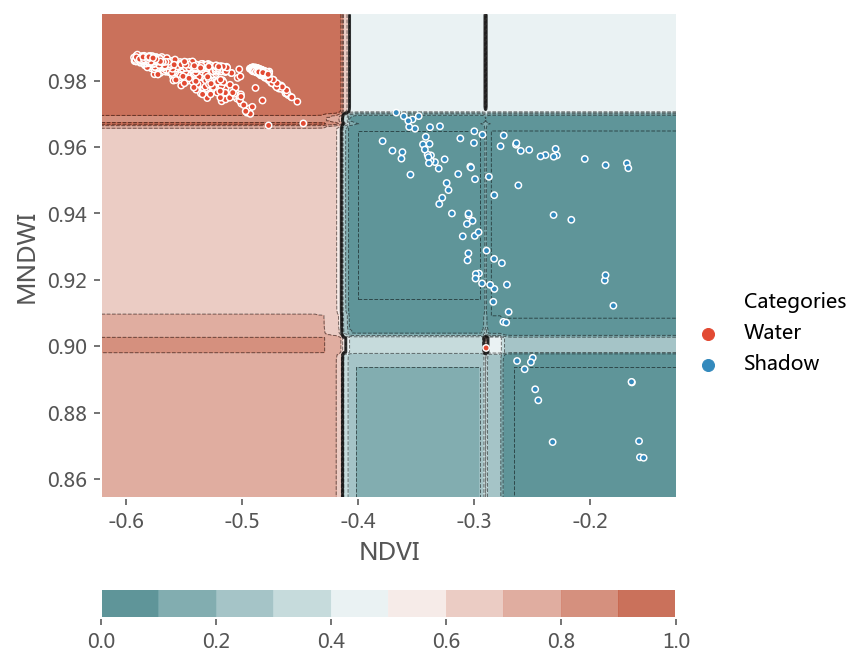

In [625]:
selected_categories = ['Shadow','Water']

cmap = sns.diverging_palette(200,20,sep=20,as_cmap=True)


selected_data = input_pd[(input_pd['Categories'] == selected_categories[0]) |
                       (input_pd['Categories'] == selected_categories[1])]

model = RandomForestClassifier(n_estimators=1000, random_state=0)



features = selected_data.drop(['Categories','NDBI'],axis=1)
target = selected_data['Categories']
model.fit(features, target)


sns.relplot(data=selected_data,
            x='NDVI',
            y='MNDWI',
            hue='Categories',s=10)

plt.grid(b=False)

plot_mlp_decision_function(model)

plt.savefig(
    f'RandomForest_{selected_categories[0]}_{selected_categories[1]}.pdf',
    bbox_inches='tight')

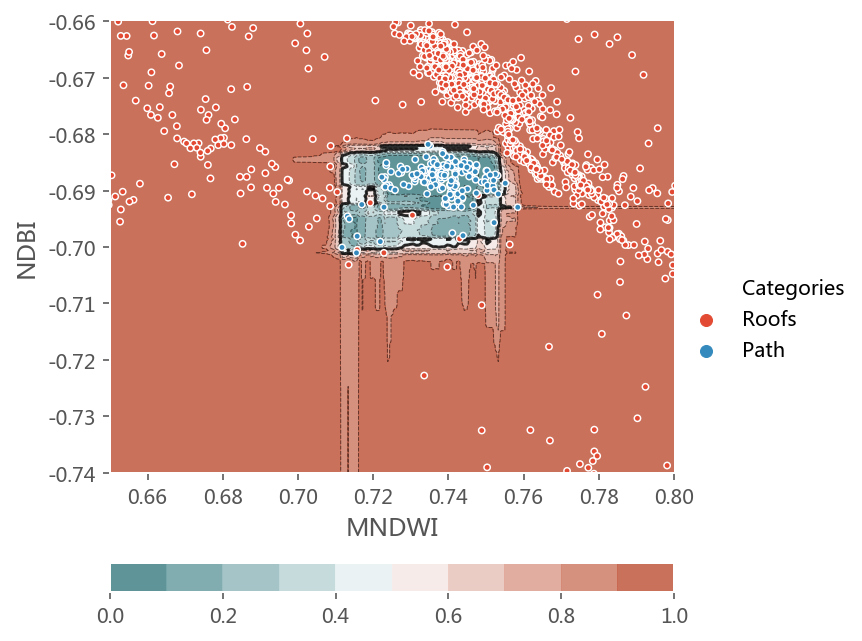

In [626]:


selected_categories = ['Roofs', 'Path']

selected_data = input_pd[(input_pd['Categories'] == selected_categories[0]) |
                       (input_pd['Categories'] == selected_categories[1])]
model = RandomForestClassifier(n_estimators=1000, random_state=0)



features = selected_data.drop(['Categories','NDVI'],axis=1)
target = selected_data['Categories']
model.fit(features, target)


sns.relplot(data=selected_data,
            y='NDBI',
            x='MNDWI',
            hue='Categories',s=10)
plt.xlim(0.65,0.80)
plt.ylim(-0.74,-0.66)  
ax = plt.gca()
ax.set_aspect(1.5) 

plt.grid(b=False)

plot_mlp_decision_function(model)

plt.savefig(
    f'RandomForest_{selected_categories[0]}_{selected_categories[1]}.pdf',
    bbox_inches='tight')

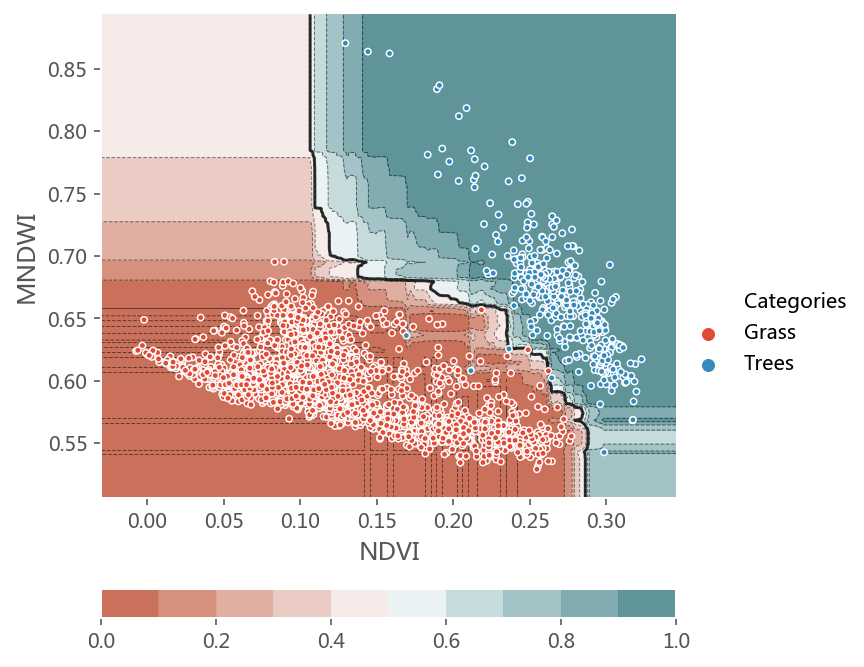

In [629]:


selected_categories = ['Grass','Trees']

cmap = sns.diverging_palette(20,200,sep=20,as_cmap=True)

selected_data = input_pd[(input_pd['Categories'] == selected_categories[0]) |
                       (input_pd['Categories'] == selected_categories[1])]

model = RandomForestClassifier(n_estimators=1000, random_state=0)



features = selected_data.drop(['Categories','NDBI'],axis=1)
target = selected_data['Categories']
model.fit(features, target)


sns.relplot(data=selected_data,
            x='NDVI',
            y='MNDWI',
            hue='Categories',s=10)

plt.grid(b=False)

plot_mlp_decision_function(model)

plt.savefig(
    f'RandomForest_{selected_categories[0]}_{selected_categories[1]}.pdf',
    bbox_inches='tight')